In [1]:
from class_and_functions_for_combinations import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device("cpu")


/home/irong/dlenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
lane_keeper_ahead = HEstimator()
lane_keeper_ahead.to(device)

name_dataset = 'saved_tests/train18' #'saved_tests/train18' #'saved_tests/sim_dataset0'
#create dataset #takes a long time but then training is faster
train_dataset = MyDataset(name_dataset, he_distances=[0.8], device=device)

#split dataset into train and val
train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# DATALOADERS
train_dataloader = DataLoader(train_dataset, batch_size=8*8192, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8192, shuffle=False)

decompressing...
Dataset: saved_tests/train18
Dataset length: 9805


9805it [00:10, 942.38it/s] 

size in RAM: 0.07480621337890625 GB


In [4]:
# TRAINING 
#parameters
lr = 0.003 #0.005
epochs = 100 #500
#regularization is applied only to convolutional section, add weight decay to apply it to all layers
L1_lambda = 1e-4 #9e-4
L2_lambda = 1e-2 #1e-2
optimizer = torch.optim.Adam(lane_keeper_ahead.parameters(), lr=lr, weight_decay=9e-5) #wd = 2e-3# 3e-5
regr_loss_fn1 = nn.MSELoss() #before epochs/2
regr_loss_fn2 = nn.MSELoss() #after epochs/2 for finetuning

best_val = 100
best_epoch = 0

for epoch in range(epochs):
    # try:
    if True:
        regr_loss_fn = regr_loss_fn1 if epoch < epochs//2 else regr_loss_fn2
        he_loss = train_epoch(lane_keeper_ahead, train_dataloader, regr_loss_fn, optimizer, L1_lambda, L2_lambda)
        val_he_loss = val_epoch(lane_keeper_ahead, val_dataloader, regr_loss_fn)
        clear_output(wait=False)
    # except Exception as e:
    #     print(e)
    #     torch.cuda.empty_cache()
    #     continue
    if val_he_loss < best_val:
        best_val = val_he_loss
        best_epoch = epoch
        torch.save(lane_keeper_ahead.state_dict(), model_name)
        print("model saved")
    
    print(f"Epoch  {epoch+1}/{epochs},  loss = {regr_loss_fn} \nhe_loss: {he_loss:.4f},   Val: {val_he_loss:.4f}, best_val: {best_val:.4f}, best_epoch: {best_epoch}")
    # print(f"lat_err_loss2: {err_loss2:.4f},   Val: {val_loss2:.4f}")
    # print(f"curv_loss: {curv_loss}")

#Note: sweet spot for training is around 0.016 -> 0.020, also note that training can get stuck, and loss can start improving randomly

Epoch  100/100,  loss = MSELoss() 
he_loss: 0.0825,   Val: 0.1397, best_val: 0.0928, best_epoch: 86


In [6]:
# EVALUATE ON TEST SET (UNSEEN DATA)
lane_keeper_ahead.load_state_dict(torch.load(model_name))
he_loss = val_epoch(lane_keeper_ahead, val_dataloader, regr_loss_fn)

# print(f"lateral_err2_loss: {err_loss2}")
print(f"he loss: {he_loss}")

100%|██████████| 1/1 [00:00<00:00, 72.62it/s]

he loss: 0.09282910823822021


(4, 1, 5, 5)
(4, 4, 5, 5)
(32, 4, 5, 5)


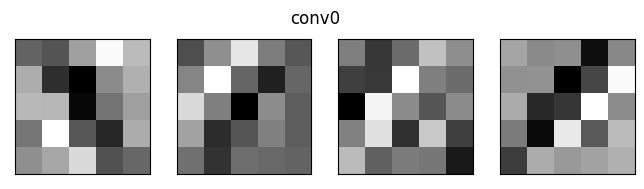

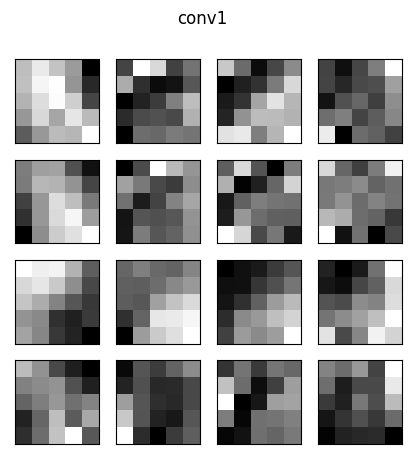

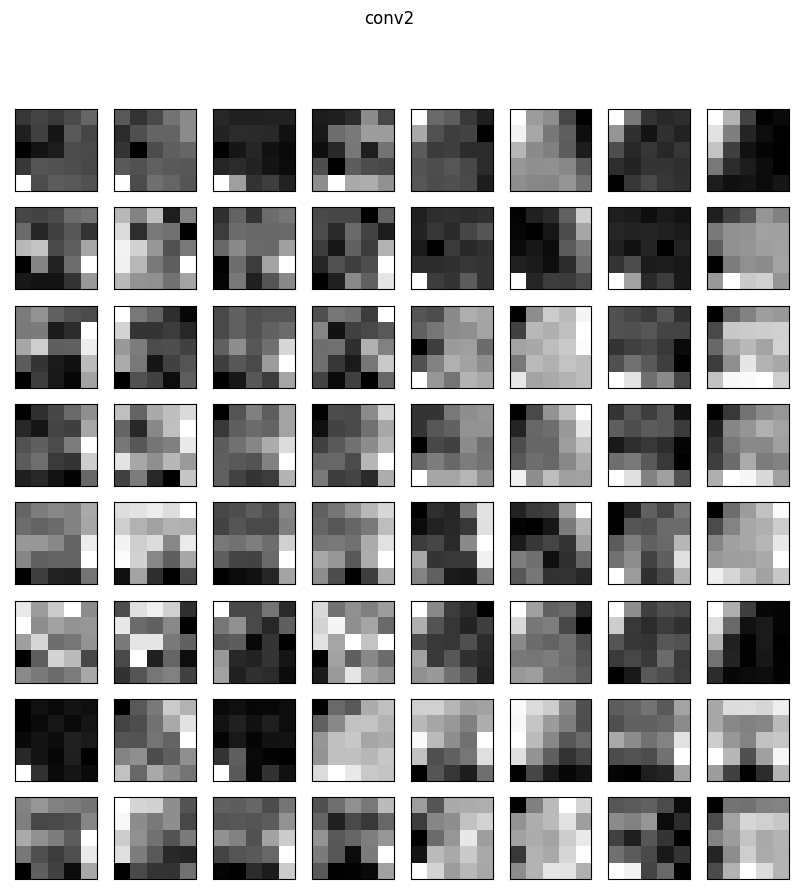

In [7]:
# VISUALIZE CONVOLUTIONAL FILTERS
conv_layers = []
children = list(lane_keeper_ahead.children())
for i in range(len(children)):
    if isinstance(children[i], nn.Conv2d):
        conv_layers.append(children[i])
    elif isinstance(children[i], nn.Sequential):
        for child in children[i].children():
            if isinstance(child, nn.Conv2d):
                conv_layers.append(child)

c0 = conv_layers[0].weight.data.cpu().numpy()
c1 = conv_layers[1].weight.data.cpu().numpy()
c2 = conv_layers[2].weight.data.cpu().numpy()

def plot_nchw_data(data, h_num, v_num, title, size=(10, 10)):
    fig, axs = plt.subplots(h_num, v_num, figsize=size)
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    #plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()
    return fig

# fig0 = plot_nchw_data(c0, 4, 4, 'conv0')
print(c0.shape)
print(c1.shape)
print(c2.shape)

fig0 = plot_nchw_data(c0, 1, 4, 'conv0', size=(8,2))

fig1 = plot_nchw_data(c1, 4, 4, 'conv1', size=(5,5)) 

fig2 = plot_nchw_data(c2, 8, 8, 'conv2', size=(10,10))

